# Защита персональных данных клиентов

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Выводы-по-работе" data-toc-modified-id="Выводы-по-работе-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы по работе</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li><li><span><a href="#Финальные-комментарии-ревьюера" data-toc-modified-id="Финальные-комментарии-ревьюера-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Финальные комментарии ревьюера</a></span></li></ul></div>

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

In [2]:
# импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

sns.set(font_scale=2,
        style='whitegrid',
        rc={'figure.figsize': (20, 16)})

import warnings
warnings.filterwarnings("ignore")

## Загрузка данных

Загрузим данные безопасным способом, выведем случайные 5 строк, общую информацию о датасете (вместе с информацией об абсолютном и относительном количестве пропусков), основные статистики по столбцам и количество явных дубликатов.

Для удобства работы весь процесс реализуем через функции.

In [3]:
try:
    data = pd.read_csv('/datasets/insurance.csv')
except:
    data = pd.read_csv('insurance.csv')

In [4]:
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [6]:
def nans(df):
    '''функция выводит количество пропусков в каждом столбце и их долю от общего количества данных в столбце'''
    
    count_missing = df.isna().sum()
    percent_missing = round(df.isna().sum() * 100 / len(df), 2)
    
    missing_value_df = pd.DataFrame({'num_missing': count_missing,
                                     'percent_missing': percent_missing})
    
    return missing_value_df.reset_index().rename(columns={'index':'column'})

In [7]:
def info_dataframe(data, details=False):
    '''функция преобразует df.info() в датафрейм'''
    
    dfInfo = data.columns.to_frame(name='column')
    dfInfo['dtype'] = data.dtypes
    dfInfo['non_null_count'] = data.notna().sum()  
    dfInfo.reset_index(drop=True, inplace=True)
    
    if details:
        rangeIndex = (dfInfo['non_null_count'].min(), dfInfo['non_null_count'].min())
        totalColumns = dfInfo['column'].count()
        dtypesCount = dfInfo['dtype'].value_counts()
        totalMemory = dfInfo.memory_usage().sum()
        return dfInfo, rangeIndex, totalColumns, dtypesCount, totalMemory
    else:
        return dfInfo

In [8]:
def all_info(df):
    '''функция выводит случайные 5 строк, информацию по датафрейму, включая пропуски и их долю, статистики и кол-во дубликатов'''
    
    display(df.sample(5))
    print(f'Датафрейм содержит {df.shape[0]} записей и {df.shape[1]} колонки')
    all_info_df = info_dataframe(df).merge(nans(df), on='column')
    display(all_info_df)
    display(df.describe()) 
    print(f'Количество явных дубликатов в датафрейме {df.duplicated().sum()}')

In [9]:
all_info(data)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
1411,1,31.0,21600.0,0,0
3256,1,26.0,46800.0,2,0
4544,1,31.0,21000.0,1,0
205,0,25.0,45000.0,0,0
876,1,38.0,42700.0,1,0


Датафрейм содержит 5000 записей и 5 колонки


,column,dtype,non_null_count,num_missing,percent_missing
0,Пол,int64,5000,0,0.0
1,Возраст,float64,5000,0,0.0
2,Зарплата,float64,5000,0,0.0
3,Члены семьи,int64,5000,0,0.0
4,Страховые выплаты,int64,5000,0,0.0


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Количество явных дубликатов в датафрейме 153


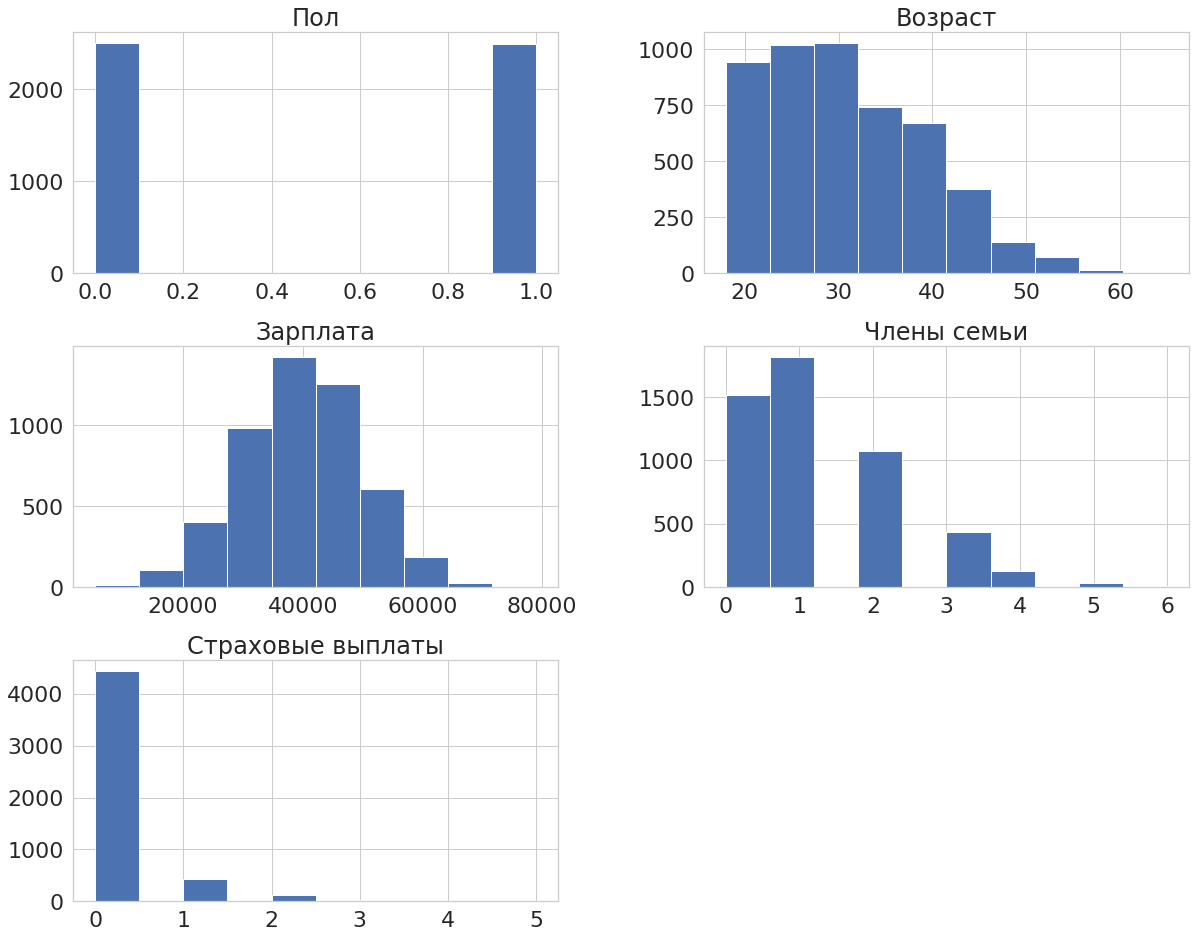

In [10]:
# визуализируем распределение данных во всех столбцах датафрейма
data.hist();

In [11]:
# более точно посмотрим на распределение значений в столбце с целевым признаком 
data['Страховые выплаты'].value_counts()

0    4436
1     423
2     115
3      18
4       7
5       1
Name: Страховые выплаты, dtype: int64

Проверим корреляцию наших признаков между собой и с таргетом.

In [12]:
data.corr()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
Пол,1.000000,0.002074,0.014910,-0.008991,0.010140
Возраст,0.002074,1.000000,-0.019093,-0.006692,0.651030
Зарплата,0.014910,-0.019093,1.000000,-0.030296,-0.014963
Члены семьи,-0.008991,-0.006692,-0.030296,1.000000,-0.036290
Страховые выплаты,0.010140,0.651030,-0.014963,-0.036290,1.000000


Сильной корреляции между признаками не обнаружено (что хорошо, так как для обычной линейной регрессии это было бы критично). Имееется достаточно высокая корреляция 0.65 между таргетом `Страховые выплаты` и  признаком `Возраст` клиента - тут наоборот, чем выше корреляция, тем лучше.

**Выводы**

Таким образом, наш датасет содержит 5 колонок и 5000 строк: каждая строка содержит полную доступную нам информацию по некоторому клиенту страховой компании «Хоть потоп», а столбцы определяют "признаки" (или "фичи") данного клиента:

- пол, 
- возраст,
- зарплата застрахованного, 
- количество членов его семьи.

Столбец `Страховые выплаты` заключает в себе целевой признак - количество страховых выплат клиенту за последние 5 лет.

Пропусков в датасете не обнаружено, однако, есть 153 явных дубликата. Столбцы с указанием возраста и зарплаты можно перевести в целочисленный тип int, так как все значение в них целые. 


Распределение клиентов по полу равномерное, по зарплате нормальное (гауссовское), а вот распределение по возрасту смещено к возрастному периоду 20-40 лет с медианой в 30. Преобладающее количество членов семьи у клиентов 0 или 1 (одинокие или с партнером без детей). Целевой признак также дисбалансно распределен: несмотря на то, что у нас есть клиенты с максимальным размером выплат 5, более 75% всех клиентов не получали страховые выплаты в течение 5 лет. 

Сильной корреляции между признаками не обнаружено.

## Умножение матриц

В этом задании вы можете записывать формулы в *Jupyter Notebook.*

Чтобы записать формулу внутри текста, окружите её символами доллара \\$; если снаружи —  двойными символами \\$\\$. Эти формулы записываются на языке вёрстки *LaTeX.* 

Для примера мы записали формулы линейной регрессии. Можете их скопировать и отредактировать, чтобы решить задачу.

Работать в *LaTeX* необязательно.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Вопрос:**

Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?

**Обоснование:**

По правилам умножения матриц имеем

1. $ АЕ = ЕА = А $
2. $ (AB)^{T} = B^{T}A^{T} $
3. $ AA^{-1} = E $
4. $ (AB)^{-1} = B^{-1}A^{-1} $

Следовательно, для ответа на этот вопрос, нужно:

- матрицу признаков $X$ умножить на некую обратимую матрицу $P$ (матрица преобразования), 
- подставить в формулу для вектора весов линейной регрессии $w$, 
- полученные выражения $XP$ и $w'$ подставить в формулу для предсказаний $a = Xw$, 
- а затем проверить, изменятся ли от этого предказания модели линейной регрессии и, соответственно, качество модели.

Возьмем исходное уравнение весов:
$$
w = (X^{T}X)^{-1}X^{T}y
$$

Подставляем в него вместо $Х$ произведение $XP$:

$$ w' = ((XP)^{T}(XP))^{-1}(XP)^{T}y $$

Раскрываем скобки, исходя из правил 2 и 4 (см.выше):

$$ w' = (P^{T}X^{T}XP)^{-1}P^{T}X^{T}y = P^{-1}(X^{T}X)^{-1}P^{T^{-1}}P^{T}X^{T}y$$

Исходя из правила 3

$$P^{T^{-1}}P^{T} = E$$

и учитывая, что по правилу 1 

$$EX^{T} = X^{T}$$

в итоге имеем новый вектор весов в виде

$$w'=P^{-1}*[(X^{T}X)^{-1}X^{T}y]=P^{-1}w$$ 

Теперь подставляем это выражение в формулу предсказаний $a = Xw$ и получаем: 

$$a' = XP*w' = XPP^{-1}w = XEw = Xw = a$$

Таким образом, мы доказали, что преобразование подобного типа не повлияет на предсказания модели, а следовательно, и на ее качество. Однако, изменится сам вектор весов модели.

**Ответ:** 

Нет, качество предсказаний модели от такого преобразования НЕ изменится.

## Алгоритм преобразования

**Алгоритм**

В основе шифрования данных клиентов будет лежать преобразование вектора признаков $X$ путем умножения его на обратную матрицу $P$, такое, что

$$X'=XP$$

Таким образом, мы сможем и защитить данные пользователей, и не потерять в качестве нашей модели машинного обучения.

Изначальная матрица признаков имеет размерность {5000, 4}, на выходе размерность данных должна остаться неизменной - 
следовательно, для шифрования нам нужно домножить матрицу признаков $X$ на квадратную обратимую матрицу размерности {4, 4}, значения в которой будут сгенерированы случайным образом с помощью генератора случайных чисел.

**Обоснование**

Сначала опишем процесс шифрования данных математически.

В общем виде решение задачи линейной регрессии по нахождению матрицы оптимальных коэффициентов (весов для модели подчиняется 

$$w=(X^TX)^{-1}X^Ty$$, где $X$ — матрица признаков, $y$ — вектор целевого признака.

При этом предсказания модель реализует через формулу $$a=Xw$$, то есть при шифровании матрицы признаков, мы получаем выражение

$$a'=X'w'$$, где $X'$ — матрица признаков после шифрования, $w'$ - веса модели, обученной на зашифрованных признаках, $a'$ — предсказания такой модели.

Так как $X'=XP$ и $w'=P^{-1}w$ (к этому выводу мы пришли выше), то

$$a' = XP(P^{-1}w) = XP*P^{-1}*[(X^{T}X)^{-1}X^{T}y] = XEw = Xw = a$$

## Проверка алгоритма

Процесс проверки алгоритма будет состоять из следующих этапов:
  
- выделение матрицы признаков и целевого признака из наших данных,
- создание случайной квадратной матрицы, по размерности совпадающей с количеством столбцов матрицы признаков наших данных, 
- проверка полученной матрицы на обратимость,
- шифрование с помощью вспомогательной матрицы изначальной матрицы признаков,
- проверка модели линейной регрессии и сравнение полученных значений метрик MSE и R2 на изначальных и зашифрованных данных.

In [13]:
# небольшая предпобработка, избавимся от дубликатов и изменим тип колонок

data['Возраст'] = data['Возраст'].astype(int)
data['Зарплата'] = data['Зарплата'].astype(int)
#data.drop_duplicates(inplace=True)

In [16]:
# выделим в наших данных матрицу признаков и целевой признак
features = data.drop('Страховые выплаты', axis=1)
target = data['Страховые выплаты']

In [17]:
# создаем случайную матрицу размерности {4, 4}
encryption_matrix = np.random.randint(10, size = (features.shape[1], features.shape[1]))
encryption_matrix

array([[7, 4, 8, 7],
       [8, 9, 1, 4],
       [5, 2, 3, 5],
       [3, 4, 5, 4]])

In [18]:
# проверяем ее на обратимость, чтобы все остальные преобразования имели смысл
encryption_matrix_inversed = np.linalg.inv(encryption_matrix)
encryption_matrix_inversed

array([[ 0.42007435,  0.11152416, -0.23420074, -0.55390335],
       [-0.16728625,  0.07063197, -0.04832714,  0.28252788],
       [ 0.31598513, -0.02230483, -0.35315985, -0.08921933],
       [-0.54275093, -0.12639405,  0.66542751,  0.49442379]])

In [19]:
# зашифруем данные путем перемножения изнаальной матрицы признаков и нашей слуайной матрицы
features_new = features @ encryption_matrix
features_new

,0,1,2,3
0,248338,99577,148854,248175
1,190371,76418,114051,190188
2,105232,42261,63029,105116
3,208674,83597,125131,208592
4,130731,52456,78336,130619
...,...,...,...,...
4995,178730,71660,107138,178620
4996,262275,105110,157239,262140
4997,169666,67988,101730,169588
4998,163692,65614,98145,163607


Напишем класс линейной регрессии, который будет реализовывать нужное нам поведение и преобразования.

In [20]:
class LinearRegression:
    
    def fit(self, features, target):
        
        # задаем матрицу признаков
        X = np.concatenate((np.ones((features.shape[0], 1)), features), axis=1)
        y = target
        
        # задаем как рассчитывается вектор весов
        w =  np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        
        # задаем веса
        self.w = w[1:]
        self.w0 = w[0]
        
    def predict(self, features):
        return features.dot(self.w) + self.w0

In [21]:
# создаем модель как объект нашего класса, обучаем ее и делаем предсказания
model = LinearRegression()
model.fit(features, target)
predictions = model.predict(features)

In [22]:
# считаем качество с помощью метрик MSE и R2
mse = mean_squared_error(target, predictions)
r2 = r2_score(target, predictions)
print('MSE модели:', mse)
print('R2 до преобразования признаков:', r2)

MSE модели: 0.12334688937098945
R2 до преобразования признаков: 0.42494550308169177


In [23]:
# проведем то же самое, но с зашифрованными признаками

model = LinearRegression()
model.fit(features_new, target)
predictions = model.predict(features_new)

mse = mean_squared_error(target, predictions)
r2 = r2_score(target, predictions)

print('MSE новой модели:', mse)
print('R2 после преобразованных признаков:', r2)

MSE новой модели: 0.12334688937141655
R2 после преобразованных признаков: 0.4249455030797006


Таким образом, как мы видим, домножение матрицы признаков на произвольную обратимую квадратную матрицу помогло нам зашифровать данные пользователей, но при этом, не повлияло на точность предсказаний модели линейной регрессии, а, как следствие, и на ее качество.

## Выводы по работе

Перед нами стояла цель, разработать такой алгоритм шифрования данных, который помог бы нам защитить персональную иинформацию клиентов страховой компании «Хоть потоп».

В ходе исследования:
    
- были загружены и изучены даннные,
- приведены математические выкладки процесса умножения матриц, в ходе которых было показано, что умножение матрицы признаков на обратимую матрицу не меняет качество линейной регрессии,
- на основании этих предпосылок был предложен и обоснован алгоритм шифрования исходных данных с помощью умножения матрицы признаков клиентов, полученной из исходного датасета, на сгенерированную случайным образом обратимую квадратную матрицу, по размерности совпадающую с количеством столбцов матрицы признаков наших данных, 
- эта стратегия была проверена с помощью самописного класса линейной регрессии и были получены такие метрики как MSE и R2 (коэффициент детерминации между реальными таргетными значениями и предсказываемыми),
- сравнение обоих коэффициентов, полученных на исходных фичах и фичах после шифрования, показало, что они практически не отличаются, а следовательно, наш механизм шифрования помогает защитить данные пользователя, но не влияет на качество модели линейной регрессии, с помощью которой мы получаем прогноз страховых выплат.